#### Packages

In [1]:
from libsvm.svmutil import *
from liblinear.liblinearutil import *
from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import pandas as pd
import numpy as np
import itertools
import random
import math
import sys

#### Read Data

In [2]:
df_tr0 = pd.read_csv("ML_FP_train.csv") # 原始資料
df_t0 = pd.read_csv("ML_FP_test.csv") # 原始資料
df_tr = pd.read_csv("train_ouo_bert_pca3.csv")
df_t = pd.read_csv("test_ouo_bert_pca3.csv")

df_tr['Danceability'] = df_tr0['Danceability']
df_t['id'] = df_t0['id']

# df_tr.shape (17170, 29)
# random_rows = df_tr.sample(n=10)
# print(random_rows)
print(df_tr.columns)

count_tr = df_tr.isna().any(axis=1).sum()
count_t = df_t.isna().any(axis=1).sum()
print("Number of rows with at least one NaN value in train data:", count_tr)
print("Number of rows with at least one NaN value in test data:", count_t)


Index(['Energy', 'Key', 'Loudness', 'Speechiness', 'Acousticness',
       'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Duration_ms',
       'Views', 'Likes', 'Stream', 'Composer', 'Artist', 'Licensed',
       'official_video', 'Album_type', '0', '1', '2', 'Danceability'],
      dtype='object')
Number of rows with at least one NaN value in train data: 0
Number of rows with at least one NaN value in test data: 0


In [5]:
df_tr.describe()

,Danceability,Energy,Key,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration_ms,Views,Likes,Stream,Composer,Artist,Licensed,official_video,Album_type
count,17170.000000,16794.000000,14568.000000,16758.000000,14655.000000,1.675800e+04,14569.000000,14635.000000,14596.000000,14608.000000,1.456700e+04,1.677200e+04,1.677200e+04,1.460200e+04,17170.000000,14604.000000,17170.000000,17170.000000,14610.000000
mean,4.586022,0.335793,5.231604,-7.553714,0.095462,1.154138e-01,0.054934,0.033745,0.525842,120.937819,2.228307e+05,8.825005e+07,6.475923e+05,1.290426e+08,5.569948,47.864352,0.597554,0.669249,1.778713
std,2.858980,0.234146,3.456986,4.381722,0.103068,2.145250e-01,0.191392,0.114862,0.244912,29.665225,1.211659e+05,2.462447e+08,1.644600e+06,2.417681e+08,3.025803,25.821948,0.490405,0.470497,0.490556
min,0.000000,-0.038443,0.000000,-46.251000,0.000000,1.367631e-18,0.000000,0.000003,0.000000,0.000000,3.098500e+04,2.600000e+01,0.000000e+00,6.574000e+03,0.000000,1.000000,0.000000,0.000000,1.000000
25%,2.000000,0.144703,2.000000,-8.492000,0.036100,2.106449e-04,0.000000,0.000836,0.336000,97.041000,1.793055e+05,2.809032e+06,3.163875e+04,1.628195e+07,3.000000,27.000000,0.000000,0.000000,1.000000
50%,5.000000,0.302112,5.000000,-6.401412,0.051400,1.677722e-02,0.000002,0.001907,0.531000,119.995500,2.120300e+05,2.258264e+07,1.882330e+05,4.550224e+07,6.000000,48.000000,1.000000,1.000000,2.000000
75%,7.000000,0.493039,8.000000,-5.128250,0.106000,1.092154e-01,0.000392,0.012487,0.722000,139.990250,2.495115e+05,7.367898e+07,5.548997e+05,1.256493e+08,8.000000,69.000000,1.000000,1.000000,2.000000
max,9.000000,1.000000,10.000000,0.829000,0.964000,1.416748e+00,1.000000,1.000000,0.993000,243.372000,4.581483e+06,5.773798e+09,4.014762e+07,3.386520e+09,10.000000,95.000000,1.000000,1.000000,3.000000


##### Levels of Danceability, Barplot

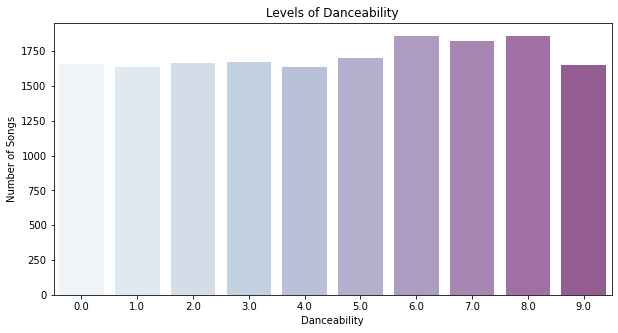

In [6]:
df_tr["Danceability"] = df_tr["Danceability"].astype("category")
# Target Variable Countplot
plt.figure(figsize = (10, 5))
sns.countplot(data=df_tr, x="Danceability", alpha = .70, palette = "BuPu")
plt.title("Levels of Danceability")
plt.ylabel("Number of Songs")
plt.show()

df_tr["Danceability"] = df_tr["Danceability"].astype("int")

##### Correlation Matrix, Heatmap

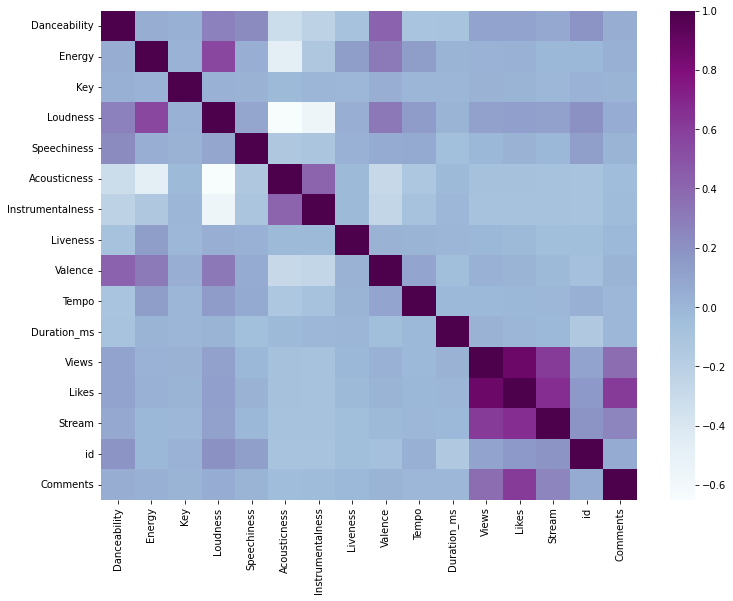

In [5]:
df_tr_oy = pd.read_csv("ML_FP_train.csv") # 原始資料但歐陽
# Heatmap
plt.figure(figsize=(12, 9))
sns.heatmap(df_tr_oy.corr(), cmap="BuPu")
plt.show()

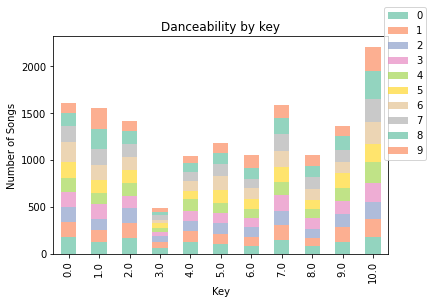

In [8]:
# Danceability by key Visualization
colors = sns.color_palette("Set2")
key = df_tr.groupby(["Key","Danceability"]).Key.count().unstack()
p1 = key.plot(kind = "bar", stacked = True, 
                   title = "Danceability by key", 
                   color = colors, alpha = .70)
p1.set_xlabel("Key")
p1.set_ylabel("Number of Songs")
plt.legend(bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure)
plt.show()

### Model

#### OLS

##### OLS, self-choosing

In [8]:
dep_var = 'Danceability'
indep_selfpick_var = ['Key', 'Loudness', 'Speechiness', 'Acousticness', 'Valence']

y_tr = df_tr[dep_var]
X_tr = df_tr[indep_selfpick_var]
X_t = df_t[indep_selfpick_var]

# with statsmodels
X_tr = sm.add_constant(X_tr) # adding a constant
X_t = sm.add_constant(X_t)
ols_model = sm.OLS(y_tr, X_tr).fit()

ols_predictions_t = ols_model.predict(X_t) 
# Round the predicted values to the nearest integer and convert to integers
ols_predictions_t = predictions_t.round().astype(int)
# Map the predicted values to the range {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
ols_predictions_t = predictions_t.clip(0, 9)

print_ols_model = ols_model.summary()
print(print_ols_model)

ols_predictions_df = pd.DataFrame({'id': df_t['id'], 'Danceability': ols_predictions_t})
ols_predictions_df.to_csv('ols_submission.csv', index=False)

MissingDataError: exog contains inf or nans

##### check distribution of danceability

In [9]:
ols_predictions_df["Danceability"] = ols_predictions_df["Danceability"].astype("category")
# Target Variable Countplot
plt.figure(figsize = (10, 5))
sns.countplot(data=ols_predictions_df, x="Danceability", alpha = .70, palette = "BuPu")
plt.title("Levels of Danceability")
plt.ylabel("Number of Songs")
plt.show()

ols_predictions_df["Danceability"] = ols_predictions_df["Danceability"].astype("int")

NameError: name 'ols_predictions_df' is not defined

###### Score: 2.14919

#### SVM

In [6]:
dep_var = 'Danceability'
indep_var = [col for col in df_tr.columns if col != dep_var]

y_tr = df_tr[dep_var]
X_tr = df_tr[indep_var].values.tolist()
X_t = df_t[indep_var].values.tolist()

# Standardize the input features
scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_tr)
X_t_scaled = scaler.transform(X_t)
# Fill NaN values with 0
X_tr_scaled = np.nan_to_num(X_tr_scaled, nan=0)
X_t_scaled = np.nan_to_num(X_t_scaled, nan=0)
X_tr_scaled = pd.DataFrame(X_tr_scaled, columns=indep_var)
X_t_scaled = pd.DataFrame(X_t_scaled, columns=indep_var)

y_tr = df_tr[dep_var].values.tolist()
X_tr_scaled = X_tr_scaled.values.tolist()
X_t_scaled = X_t_scaled.values.tolist()

##### C=1

###### Missing value = 0 & Standardize

Accuracy = 17.023% (1075/6315) (classification)


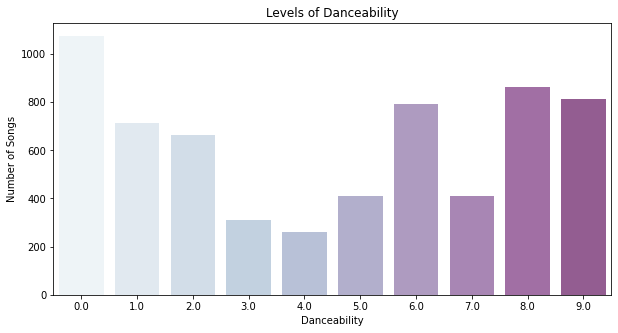

In [7]:
# linear kernel: -t=0
hard_svm_param = f'-s 0 -t 0 -c 1 -q'
hard_svm_model = svm_train(y_tr, X_tr_scaled , hard_svm_param)
hard_svm_predictions_t, _, _ = svm_predict([], X_t_scaled, hard_svm_model)

hard_svm_predictions_df = pd.DataFrame({'id': df_t['id'], 'Danceability': hard_svm_predictions_t})
hard_svm_predictions_df.to_csv('svm_hard_scaledn.csv', index=False)

hard_svm_predictions_df["Danceability"] = hard_svm_predictions_df["Danceability"].astype("category")
# Target Variable Countplot
plt.figure(figsize = (10, 5))
sns.countplot(data=hard_svm_predictions_df, x="Danceability", alpha = .70, palette = "BuPu")
plt.title("Levels of Danceability")
plt.ylabel("Number of Songs")
plt.show()

##### C=0.1

Accuracy = 18.5273% (1170/6315) (classification)


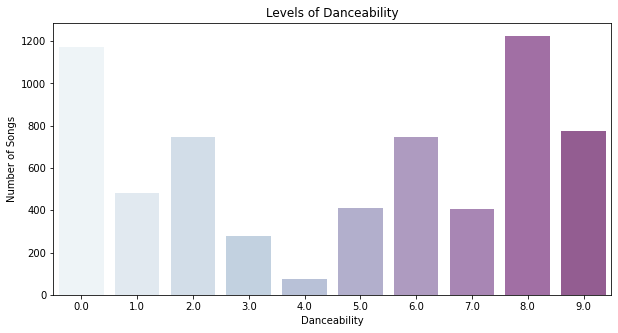

In [16]:
# linear kernel: -t=0
soft_svm_param = f'-s 0 -t 0 -c 0.1 -q'
soft_svm_model = svm_train(y_tr, X_tr_scaled , soft_svm_param)
soft_svm_predictions_t, _, _ = svm_predict([], X_t_scaled, soft_svm_model)

soft_svm_predictions_df = pd.DataFrame({'id': df_t['id'], 'Danceability': soft_svm_predictions_t})
soft_svm_predictions_df.to_csv('svm_soft_submission.csv', index=False)
soft_svm_predictions_df["Danceability"] = soft_svm_predictions_df["Danceability"].astype("category")

# Target Variable Countplot
plt.figure(figsize = (10, 5))
sns.countplot(data=soft_svm_predictions_df, x="Danceability", alpha = .70, palette = "BuPu")
plt.title("Levels of Danceability")
plt.ylabel("Number of Songs")
plt.show()

##### C= 0.01

Accuracy = 17.7356% (1120/6315) (classification)


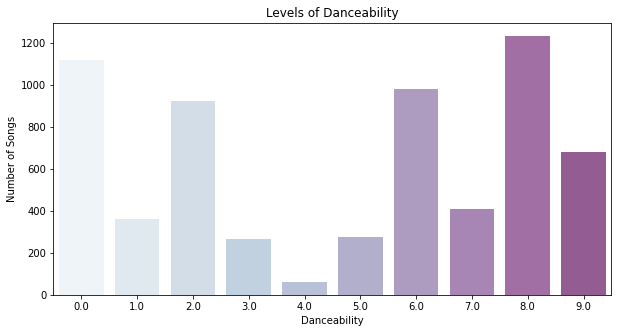

In [17]:
# linear kernel: -t=0
softer_param = f'-s 0 -t 0 -c 0.01 -q'
softer_svm_model = svm_train(y_tr, X_tr_scaled , softer_param)
softer_svm_predictions_t, _, _ = svm_predict([], X_t_scaled, softer_svm_model)

softer_svm_predictions_df = pd.DataFrame({'id': df_t['id'], 'Danceability': softer_svm_predictions_t})
softer_svm_predictions_df.to_csv('svm_softer_submission.csv', index=False)

softer_svm_predictions_df["Danceability"] = softer_svm_predictions_df["Danceability"].astype("category")
# Target Variable Countplot
plt.figure(figsize = (10, 5))
sns.countplot(data=softer_svm_predictions_df, x="Danceability", alpha = .70, palette = "BuPu")
plt.title("Levels of Danceability")
plt.ylabel("Number of Songs")
plt.show()

##### Gaussian Kernel

Accuracy = 18.5115% (1169/6315) (classification)


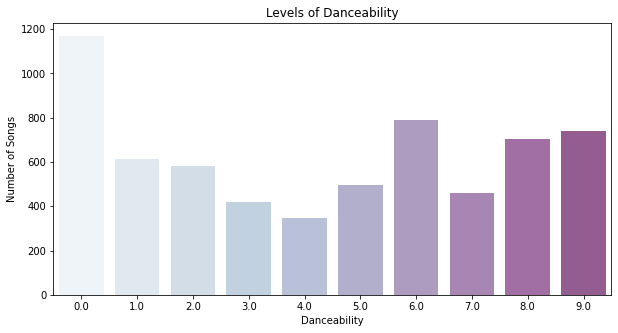

In [8]:
# Gaussian kernel: -t=2
gaussian_svm_param = f'-s 0 -t 2 -c 1 -g 0.1 -q'
gaussian_svm_model = svm_train(y_tr, X_tr_scaled , gaussian_svm_param)
gaussian_svm_predictions_t, _, _ = svm_predict([], X_t_scaled, gaussian_svm_model)

gaussian_svm_predictions_df = pd.DataFrame({'id': df_t['id'], 'Danceability': gaussian_svm_predictions_t})
gaussian_svm_predictions_df.to_csv('gaussian_svm.csv', index=False)

gaussian_svm_predictions_df["Danceability"] = gaussian_svm_predictions_df["Danceability"].astype("category")
# Target Variable Countplot
plt.figure(figsize = (10, 5))
sns.countplot(data=gaussian_svm_predictions_df, x="Danceability", alpha = .70, palette = "BuPu")
plt.title("Levels of Danceability")
plt.ylabel("Number of Songs")
plt.show()

##### Polynomial Kernel

Accuracy = 14.4418% (912/6315) (classification)


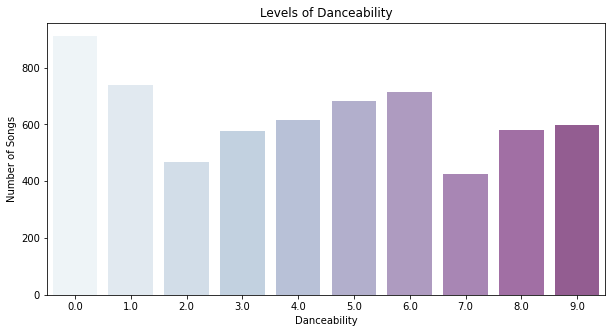

In [9]:
# Polynomial kernel: -t=1
polynomial_svm_param = f'-s 0 -t 1 -r 1 -d 3 -c 0.1 -g 1 -q'
polynomial_svm_model = svm_train(y_tr, X_tr_scaled , polynomial_svm_param)
polynomial_svm_pred_t, _, _ = svm_predict([], X_t_scaled, polynomial_svm_model)

polynomial_svm_pred_df = pd.DataFrame({'id': df_t['id'], 'Danceability': polynomial_svm_pred_t})
polynomial_svm_pred_df.to_csv('polynomial_svm.csv', index=False)

polynomial_svm_pred_df["Danceability"] = polynomial_svm_pred_df["Danceability"].astype("category")
# Target Variable Countplot
plt.figure(figsize = (10, 5))
sns.countplot(data=polynomial_svm_pred_df, x="Danceability", alpha = .70, palette = "BuPu")
plt.title("Levels of Danceability")
plt.ylabel("Number of Songs")
plt.show()